# Рекомендация тарифов

## 1. Изучение данных

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# импорт необходимых модулей
import sys
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from urllib.parse import urlencode
from time import perf_counter,sleep
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [3]:
LINK = "https://yadi.sk/d/_b6QZy0FtTZdPw"

In [4]:
def get_url(link):
    """
    Получение адреса для скачивания с Яндекс.Диск
    link - ссылка на Яндекс.Диск
    """
    print("Run", link)
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    url = response.json()['href']
    return url

In [5]:
def get_true_range(s, k=1.5):
    """
    Функция для получения границ диапазона [-k*iqr, +k*iqr]
    
    s - данные типа Series
    k - коэффициент для вычисления доверительного интервала (default=1.5)
    """
    iqr = st.iqr(s)
    quantile = s.quantile([.25, .75])
    first = round(quantile[0.25] - k * iqr, 2)
    third = round(quantile[0.75] + k * iqr, 2)
    return (first, third)

In [6]:
def get_boxplot(df, x, y, loc='lower right', orient='h', size=(15,8)):
    """
    Функция для построения диаграммы размаха.
    
    df   - данные
    x    - признак, по которым демонстрируется диаграмма размаха
    y    - признак, для которого демонстрируется x
    loc  - расположение легенды на графике
    size - размер графика
    """
    title = 'The Box Plot of {} for {}'.format(x, y)
    
    fig, ax = plt.subplots(figsize=size)
        
    sns.boxplot(y=y, x=x, orient=orient,
                     data=df, 
                     palette="colorblind",
                     hue=y, ax=ax)
    
    ax.title.set_text(title)
    ax.yaxis.grid(False)
    ax.xaxis.grid(True)
    plt.legend(loc=loc)
    plt.show()

In [7]:
def check_accuracy(accuracy):
    """
    Функция для проверки условия задачи.
    
    accuracy - точность
    """
    return 'OK    ' if accuracy >= 0.75 else 'FAIL  '

In [8]:
def research_model(m, X_train, y_train, X_valid, y_valid):
    """
    Функция исследования модели.
    
    m - модель,выбранная для обучения
    X_train - признаки обучающей выборки
    y_train - целевая переменная обучающей выборки
    X_valid - признаки валидационной выборки
    y_valid - целевая переменная валидационной выборки
    """
    # время обучения
    t1 = perf_counter()
    m.fit(X_train, y_train)
    timer = perf_counter() - t1
    
    accuracy_train = m.score(X_train, y_train)
    accuracy_valid = m.score(X_valid, y_valid)
    
    info = [check_accuracy(accuracy_valid), type(m).__name__]
    info.extend(round(i, 4) for i in [accuracy_train, accuracy_valid, timer])
    print("{} {} - accuracy {} -> {}   ({} sec)".format(*info)) 
    return accuracy_train, accuracy_valid, timer

In [9]:
def get_figure(df, x, y, ax, get_thresh=True, y_thresh=0.75, color='blue',
               y_name='None', ymin=0.65, ymax=1.05):
    """
    Функция построения графика.
    
    df - данные
    x  - признак х
    y  - признак y
    ax - ось
    get_thresh=True - обозначение, рисовать пороговые линии или нет
    y_thresh=0.75   - пороговая линия по оси y (по умолчанию 0.75)
    color='blue'    - цвет
    y_name          - имя оси y
    ymin            - минимальное y-значение
    ymax            - максимальное y-значение
    """
    
    y_max = df[y].max()
    x_max = df[df[y] == y_max].sort_values(by=[x])[x].min()
    
    title = 'The dependence of {} the {} on the {}'.format(df.name, y_name, x)
    
    annotate_text = '{} = {}'.format(x,x_max)
    annotate_xy=(x_max+0.2, 0.9)
    
    ax.title.set_text(title)
    df.plot(x=x, y=y, ax=ax, color=color)
    
    if get_thresh:
        # граница y
        ax.axhline(y=y_thresh, color='r', linestyle=':')
        # значение параметра, при котором достигается максимальное y-значение
        ax.axvline(x=x_max, color=color, alpha=0.5, linestyle=':')
        ax.annotate(annotate_text, annotate_xy, rotation=90)
    
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.set_ylabel(y_name)

In [10]:
def drop_values(df, group, param):
    """
    Функция удаления выбросов.
    
    df    - данные
    group - признак для группировки
    param - признак для поиска выбросов
    """
    
    groups = list(df[group].unique())
    
    for gr in groups:
        first, second = get_true_range(df[df[group] == gr][param])        
        df.drop(
            df[(df[group] == gr) & ((df[param] < first) | (df[param] > second))].index,
            axis=0,
            inplace=True
        )
    
    return df

In [11]:
data = pd.read_csv(get_url(LINK))
data.sample(5)

Run https://yadi.sk/d/_b6QZy0FtTZdPw


,calls,minutes,messages,mb_used,is_ultra
1458,28.0,205.77,61.0,25839.00,0
291,123.0,873.57,71.0,4153.55,1
1294,40.0,280.44,2.0,13934.54,0
2082,56.0,368.11,36.0,16003.15,0
1104,17.0,141.05,14.0,9850.74,0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [13]:
# диаграммы размаха для каждого признака
def tariff_boxplot(df):
    features = ['calls', 'minutes', 'messages', 'mb_used']

    for feature in features:
        get_boxplot(df, x=feature, y='is_ultra', loc='upper right', 
                             size=(15,2))

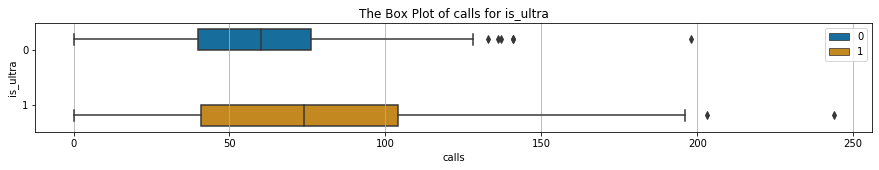

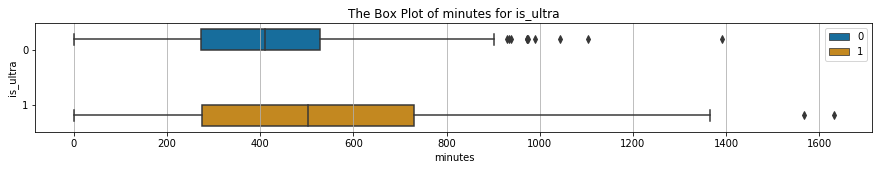

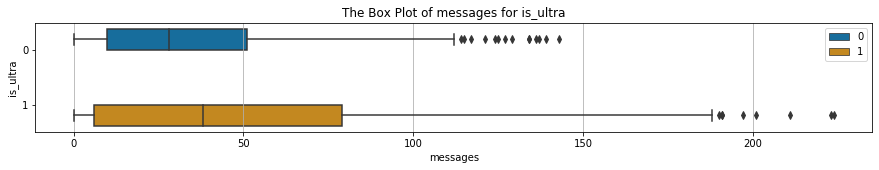

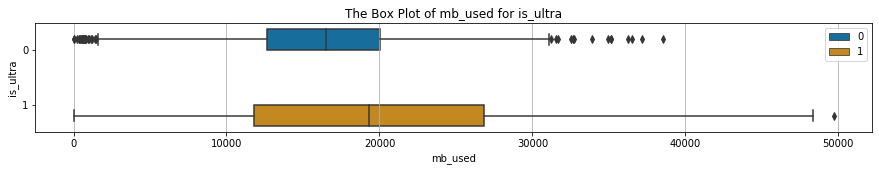

In [14]:
tariff_boxplot(data)

В данных нет пропусков, а также нет проблем с типами данных. Однако, из диаграммы размаха видно, что для разных признаков присутствуют выбросы.

Для дальнейшей работы определим признаки и целевую переменную:
* _is_ultra_ - целевая переменная
* _calls, minutes, messages, mb_used_ - признаки

## 2. Разделение данных на выборки

In [15]:
# применим стандартное разбиение 3:1
train_data, tmp_data = train_test_split(data, test_size=0.4)
valid_data, test_data = train_test_split(tmp_data, test_size=0.5)

# имена
data.name = 'general'
train_data.name = 'train'
valid_data.name = 'valid'
test_data.name = 'test'

print(data.shape)
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(3214, 5)
(1928, 5)
(643, 5)
(643, 5)


In [16]:
# посмотрим на соотношение целевых переменных в каждой из выборок
result = pd.DataFrame()

for sample in (data, train_data, valid_data, test_data):
    name = sample.name
    size = sample.shape[0]
    result[name] = round(
        sample['is_ultra'].value_counts() / size,2)
    
result.reset_index().rename(columns={"index": "is_ultra"})

,is_ultra,general,train,valid,test
0,0,0.69,0.69,0.7,0.68
1,1,0.31,0.31,0.3,0.32


In [17]:
train_features = train_data.drop(['is_ultra'], axis=1)
train_target = train_data['is_ultra']

valid_features = valid_data.drop(['is_ultra'], axis=1)
valid_target = valid_data['is_ultra']

test_features = test_data.drop(['is_ultra'], axis=1)
test_target = test_data['is_ultra']

Подробнее изучим обучающую выборку на предмет выбросов.

In [18]:
# помотрим на доверительный интервал для 2 тарифов

for tariff in [0, 1]:
    print('\nДоверительный интервал для is_ultra={}\n'.format(tariff))
    
    df = train_data[train_data.is_ultra == tariff]
    result = {'first':[], 'second':[]}

    for feature in ['calls', 'minutes', 'messages', 'mb_used']:
        first, second = get_true_range(df[feature], k=1.5)
        result['first'].append(first)
        result['second'].append(second)

    print(pd.DataFrame.from_dict(result, orient='index', columns=['calls', 'minutes', 'messages', 'mb_used']))


Доверительный интервал для is_ultra=0

        calls  minutes  messages   mb_used
first   -15.5   -93.32     -50.5   1524.62
second  132.5   901.48     113.5  31125.10

Доверительный интервал для is_ultra=1

        calls  minutes  messages   mb_used
first   -51.0  -362.55    -103.5 -12112.86
second  197.0  1384.97     188.5  50370.99


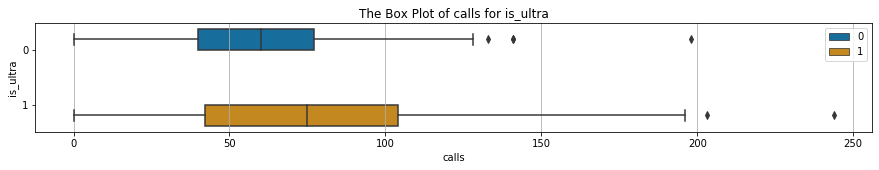

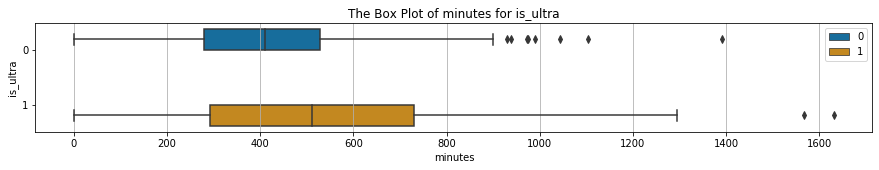

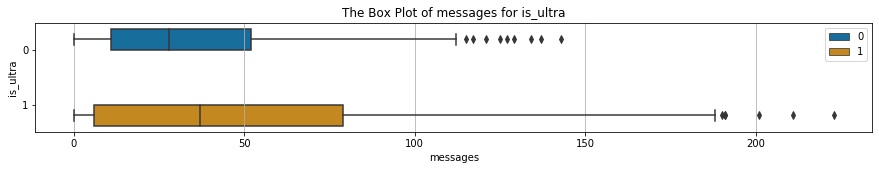

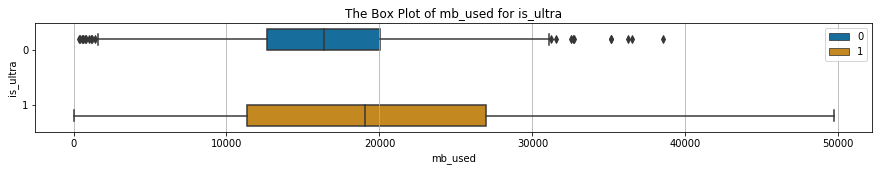

In [19]:
# посмотрим боксплоты для кадого тарифа
tariff_boxplot(train_data)

Из графиков видно, что:
1. Присутствуют выбросы для 2 тарифов;
2. Распределение всех признаков унимодальное, почти симметричное и близко к нормальному.

Удалим выбросы из обучающей выборки, так как этот момент может сказаться на последующем обучении моделей.

In [20]:
# tmp = train_data.copy()
print(train_data.shape)

for f in ['calls', 'minutes', 'messages', 'mb_used']:
    train_data = drop_values(train_data, 'is_ultra', f);
    
print(train_data.shape)

(1928, 5)
(1883, 5)


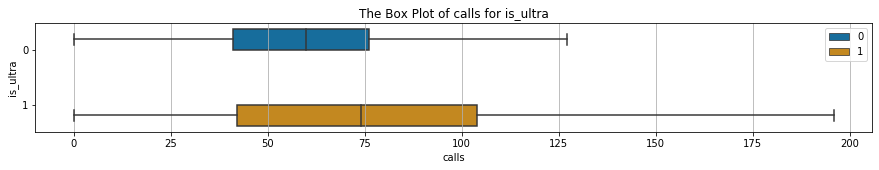

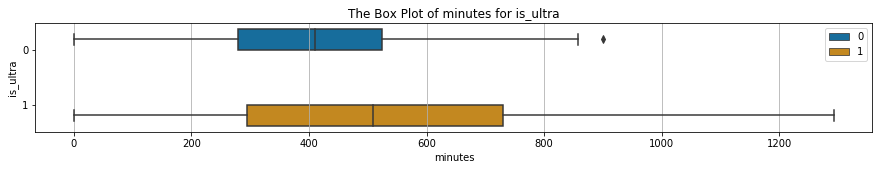

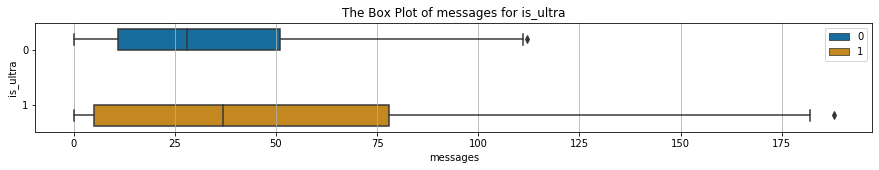

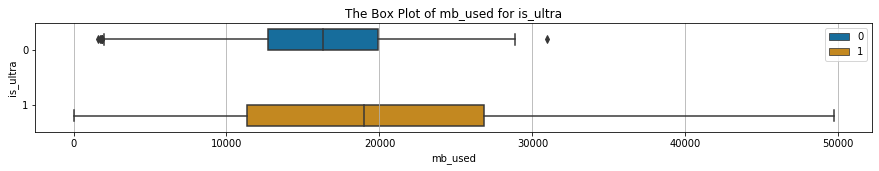

In [21]:
tariff_boxplot(train_data)

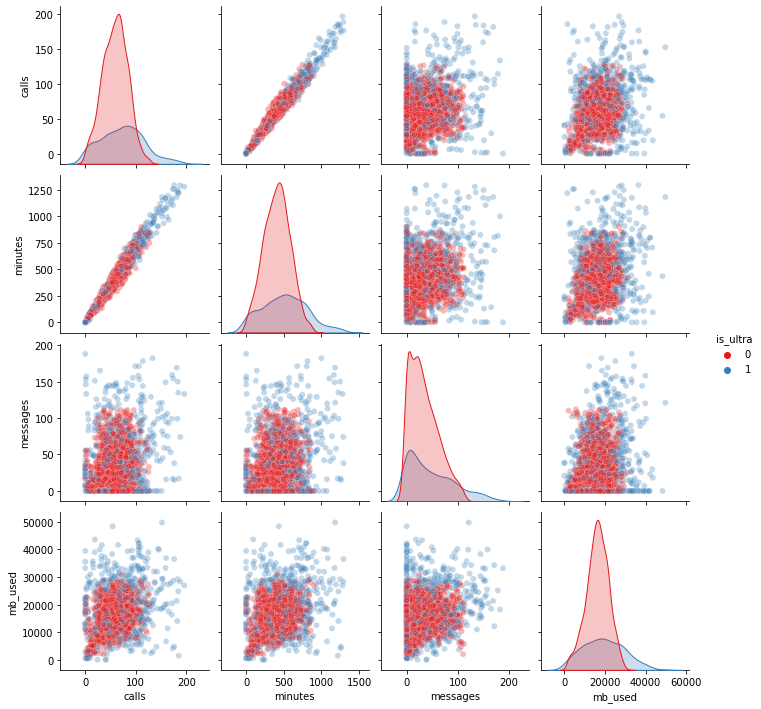

In [22]:
sns.pairplot(train_data, hue='is_ultra', palette='Set1', plot_kws={'alpha':0.3});

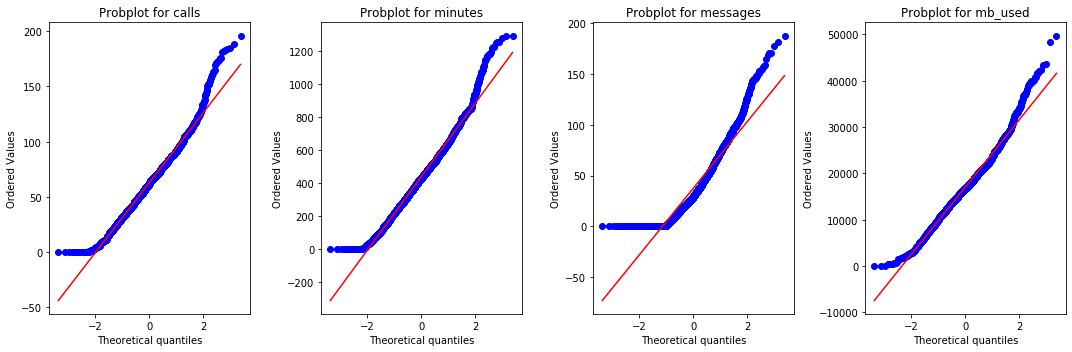

In [23]:
# посмотрим график вероятности выборки данных по квантилям распределения каждого признака
fig, axes = plt.subplots(1,4,figsize=(15,5))

for i, feature in enumerate(['calls', 'minutes', 'messages', 'mb_used']):
    st.probplot(train_data[feature], plot=axes[i])
    axes[i].set_title("Probplot for {}".format(feature))
    
fig.tight_layout()
plt.show()

Убрали выбросы, перейдем к этапу выбора моделей.

## 3. Исследование моделей

Поставлена задача _классификации_. Будем рассматривать алгоритмы:

* решающее дерево _(DecisionTreeClassifier)_
* случайный лес _(RandomForestClassifier)_
* логистическая регрессия _(LogisticRegression)_

In [24]:
# Логистическая регрессия
model = LogisticRegression(random_state=12345)
model.fit(train_features, train_target)

accuracy_train, accuracy_valid, timer = research_model(
        model, train_features, train_target, valid_features, valid_target)

OK     LogisticRegression - accuracy 0.7464 -> 0.7512   (0.1286 sec)


Алгоритм логистической регрессии демонстрирует точность ниже требуемой, поэтому этот алгоритм для данной задачи не будет рассматриваться.

In [25]:
# решающее дерево
tree_accuracy = {}

for depth in range(1, 101, 5):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    accuracy_train, accuracy_valid, timer = research_model(model, 
                                                           train_features, 
                                                           train_target, 
                                                           valid_features, 
                                                           valid_target)
    tree_accuracy[depth] = [accuracy_train, accuracy_valid, timer]

FAIL   DecisionTreeClassifier - accuracy 0.7567 -> 0.7481   (0.0143 sec)
OK     DecisionTreeClassifier - accuracy 0.8351 -> 0.7885   (0.0087 sec)
OK     DecisionTreeClassifier - accuracy 0.9004 -> 0.7885   (0.0117 sec)
FAIL   DecisionTreeClassifier - accuracy 0.971 -> 0.7185   (0.0127 sec)
FAIL   DecisionTreeClassifier - accuracy 0.9901 -> 0.7061   (0.0133 sec)
FAIL   DecisionTreeClassifier - accuracy 0.999 -> 0.7123   (0.0136 sec)
FAIL   DecisionTreeClassifier - accuracy 1.0 -> 0.7092   (0.0138 sec)
FAIL   DecisionTreeClassifier - accuracy 1.0 -> 0.7092   (0.0153 sec)
FAIL   DecisionTreeClassifier - accuracy 1.0 -> 0.7092   (0.0154 sec)
FAIL   DecisionTreeClassifier - accuracy 1.0 -> 0.7092   (0.0135 sec)
FAIL   DecisionTreeClassifier - accuracy 1.0 -> 0.7092   (0.0139 sec)
FAIL   DecisionTreeClassifier - accuracy 1.0 -> 0.7092   (0.0144 sec)
FAIL   DecisionTreeClassifier - accuracy 1.0 -> 0.7092   (0.0129 sec)
FAIL   DecisionTreeClassifier - accuracy 1.0 -> 0.7092   (0.0132 sec)
FAIL

In [26]:
tree_accuracy

{1: [0.7567427385892116, 0.7480559875583204, 0.014314559000013105],
 6: [0.8350622406639004, 0.7884914463452566, 0.008696654999766906],
 11: [0.9004149377593361, 0.7884914463452566, 0.011746350000066741],
 16: [0.970954356846473, 0.71850699844479, 0.012742568999783543],
 21: [0.9901452282157677, 0.7060653188180405, 0.013347604999580653],
 26: [0.9989626556016598, 0.7122861586314152, 0.013572214999840071],
 31: [1.0, 0.7091757387247278, 0.013754012000390503],
 36: [1.0, 0.7091757387247278, 0.015306446999602485],
 41: [1.0, 0.7091757387247278, 0.015397940000184462],
 46: [1.0, 0.7091757387247278, 0.013475765000293904],
 51: [1.0, 0.7091757387247278, 0.013944680000349763],
 56: [1.0, 0.7091757387247278, 0.01441394500034221],
 61: [1.0, 0.7091757387247278, 0.01292611200005922],
 66: [1.0, 0.7091757387247278, 0.013235579999673064],
 71: [1.0, 0.7091757387247278, 0.016808038999442942],
 76: [1.0, 0.7091757387247278, 0.013552170999901136],
 81: [1.0, 0.7091757387247278, 0.013401942000200506],

In [27]:
# данные эксперимента запишем в таблицу для дальнейшего изучения
tree = (pd
        .DataFrame
        .from_dict(tree_accuracy, orient='index')
        .reset_index()
       )

# update
tree.set_axis(['depth', 'accuracy_train', 'accuracy_valid', 'time'], axis=1, inplace=True)
# pd.__version__

tree.name = 'tree'
tree.sample(5)

,depth,accuracy_train,accuracy_valid,time
14,71,1.000000,0.709176,0.016808
1,6,0.835062,0.788491,0.008697
3,16,0.970954,0.718507,0.012743
5,26,0.998963,0.712286,0.013572
9,46,1.000000,0.709176,0.013476


In [28]:
# случайный лес (эксперименты с глубиной)
forest_accuracy = {}

for depth in range(1, 50, 1):
    model = RandomForestClassifier(random_state=12345, max_depth=depth)
    
    accuracy_train, accuracy_valid, timer = research_model(
        model, train_features, train_target, valid_features, valid_target)
    
    forest_accuracy[depth] = [accuracy_train, accuracy_valid, timer]

OK     RandomForestClassifier - accuracy 0.7495 -> 0.7543   (0.2235 sec)
OK     RandomForestClassifier - accuracy 0.7894 -> 0.7729   (0.2606 sec)
OK     RandomForestClassifier - accuracy 0.8013 -> 0.7916   (0.262 sec)
OK     RandomForestClassifier - accuracy 0.8133 -> 0.8025   (0.2993 sec)
OK     RandomForestClassifier - accuracy 0.8226 -> 0.7978   (0.3327 sec)
OK     RandomForestClassifier - accuracy 0.8377 -> 0.7978   (0.3413 sec)
OK     RandomForestClassifier - accuracy 0.8553 -> 0.8025   (0.3645 sec)
OK     RandomForestClassifier - accuracy 0.874 -> 0.7978   (0.3785 sec)
OK     RandomForestClassifier - accuracy 0.8874 -> 0.7916   (0.3993 sec)
OK     RandomForestClassifier - accuracy 0.8968 -> 0.7963   (0.4072 sec)
OK     RandomForestClassifier - accuracy 0.9077 -> 0.7916   (0.4179 sec)
OK     RandomForestClassifier - accuracy 0.9238 -> 0.7932   (0.4475 sec)
OK     RandomForestClassifier - accuracy 0.9336 -> 0.7885   (0.4569 sec)
OK     RandomForestClassifier - accuracy 0.9429 -> 0.

In [29]:
# данные эксперимента запишем в таблицу для дальнейшего изучения
forest_depth = (pd
                .DataFrame
                .from_dict(forest_accuracy, orient='index')
                .reset_index()
#                 .set_axis(['depth', 'accuracy_train', 'accuracy_valid', 'time'], axis=1)
               )

# update
forest_depth.set_axis(['depth', 'accuracy_train', 'accuracy_valid', 'time'], axis=1, inplace=True)

forest_depth.name = 'forest_depth'
forest_depth.sample(5)

,depth,accuracy_train,accuracy_valid,time
4,5,0.822614,0.797823,0.332726
8,9,0.887448,0.791602,0.399303
36,37,1.000000,0.783826,0.525512
47,48,1.000000,0.783826,0.488603
6,7,0.855290,0.802488,0.364457


In [30]:
# решающий лес (эксперименты с количеством деревьев)
forest_accuracy = {}

for num in range(1, 200, 5):
    model = RandomForestClassifier(random_state=12345, n_estimators=num)
    accuracy_train, accuracy_valid, timer = research_model(model, 
                                                           train_features, 
                                                           train_target, 
                                                           valid_features, 
                                                           valid_target)
    forest_accuracy[num] = [accuracy_train, accuracy_valid, timer]

FAIL   RandomForestClassifier - accuracy 0.8973 -> 0.7278   (0.0162 sec)
OK     RandomForestClassifier - accuracy 0.9642 -> 0.7869   (0.0332 sec)
OK     RandomForestClassifier - accuracy 0.9834 -> 0.7776   (0.065 sec)
OK     RandomForestClassifier - accuracy 0.9865 -> 0.7792   (0.08 sec)
OK     RandomForestClassifier - accuracy 0.9959 -> 0.776   (0.1065 sec)
OK     RandomForestClassifier - accuracy 0.9984 -> 0.7823   (0.1293 sec)
OK     RandomForestClassifier - accuracy 0.9979 -> 0.7776   (0.1545 sec)
OK     RandomForestClassifier - accuracy 0.9984 -> 0.7854   (0.1858 sec)
OK     RandomForestClassifier - accuracy 0.9995 -> 0.7854   (0.2166 sec)
OK     RandomForestClassifier - accuracy 0.9984 -> 0.7854   (0.2307 sec)
OK     RandomForestClassifier - accuracy 0.9995 -> 0.7838   (0.257 sec)
OK     RandomForestClassifier - accuracy 0.9995 -> 0.7823   (0.2809 sec)
OK     RandomForestClassifier - accuracy 1.0 -> 0.7823   (0.2978 sec)
OK     RandomForestClassifier - accuracy 1.0 -> 0.7854   (0

In [31]:
# данные эксперимента запишем в таблицу для дальнейшего изучения
forest_estimators = (pd.DataFrame
                     .from_dict(forest_accuracy, orient='index')
                     .reset_index()
#                      .set_axis(['estimators', 'accuracy_train', 'accuracy_valid', 'time'], axis=1)
                    )

# update
forest_estimators.set_axis(['estimators', 'accuracy_train', 'accuracy_valid', 'time'], axis=1, inplace=True)

forest_estimators.name = 'forest_estimators'
forest_estimators.sample(5)

,estimators,accuracy_train,accuracy_valid,time
16,81,1.000000,0.788491,0.411000
7,36,0.998444,0.785381,0.185829
14,71,1.000000,0.788491,0.352130
1,6,0.964212,0.786936,0.033152
32,161,1.000000,0.782271,0.782329


In [32]:
# посмотрим на то, как влияет гиперпараметр min_samples_leaf
forest_accuracy = {}

for samples_leaf in range(1, 101, 5):
    model = RandomForestClassifier(random_state=12345, 
                                   min_samples_leaf=samples_leaf)
    accuracy_train, accuracy_valid, timer = research_model(
        model, train_features, train_target, valid_features, valid_target)
    forest_accuracy[samples_leaf] = [accuracy_train, accuracy_valid, timer]

OK     RandomForestClassifier - accuracy 1.0 -> 0.7838   (0.5061 sec)
OK     RandomForestClassifier - accuracy 0.8677 -> 0.7963   (0.4345 sec)
OK     RandomForestClassifier - accuracy 0.8387 -> 0.7947   (0.4279 sec)
OK     RandomForestClassifier - accuracy 0.8273 -> 0.7932   (0.409 sec)
OK     RandomForestClassifier - accuracy 0.8205 -> 0.7916   (0.4882 sec)
OK     RandomForestClassifier - accuracy 0.8159 -> 0.7885   (0.3782 sec)
OK     RandomForestClassifier - accuracy 0.8122 -> 0.7932   (0.3814 sec)
OK     RandomForestClassifier - accuracy 0.805 -> 0.7916   (0.3728 sec)
OK     RandomForestClassifier - accuracy 0.7951 -> 0.7729   (0.3554 sec)
OK     RandomForestClassifier - accuracy 0.793 -> 0.7729   (0.4072 sec)
OK     RandomForestClassifier - accuracy 0.7941 -> 0.7714   (0.3756 sec)
OK     RandomForestClassifier - accuracy 0.7925 -> 0.7698   (0.3776 sec)
OK     RandomForestClassifier - accuracy 0.7925 -> 0.7698   (0.6443 sec)
OK     RandomForestClassifier - accuracy 0.792 -> 0.7698 

In [33]:
# данные эксперимента запишем в таблицу для дальнейшего изучения
forest_samples_leaf = (
    pd.DataFrame
    .from_dict(forest_accuracy, orient='index')
    .reset_index()
#     .set_axis(['samples_leaf','accuracy_train','accuracy_valid','time'], axis=1)
)

# update
forest_samples_leaf.set_axis(['samples_leaf','accuracy_train','accuracy_valid','time'], axis=1, inplace=True)

forest_samples_leaf.name = 'forest_samples_leaf'
forest_samples_leaf.sample(5)

,samples_leaf,accuracy_train,accuracy_valid,time
4,21,0.820539,0.791602,0.488199
7,36,0.804979,0.791602,0.372757
15,76,0.791494,0.769829,0.513771
12,61,0.792531,0.769829,0.644321
2,11,0.838693,0.794712,0.427891


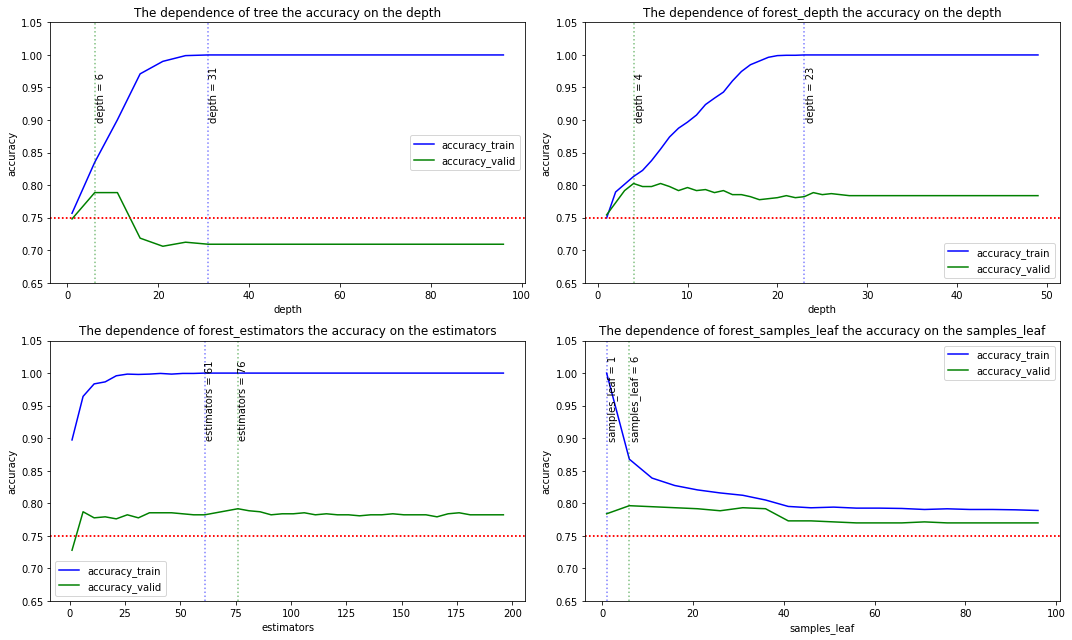

In [34]:
row = 2
col = 2
coord = [ (i,j) for i in range(row) for j in range(col)]

x_list  = ['depth','depth', 'estimators', 'samples_leaf']
df_list = [tree, forest_depth, forest_estimators, forest_samples_leaf]


fig, axes = plt.subplots(row, col, figsize=(15,9))

for idx, x, stat in zip(coord, x_list, df_list):
    get_figure(stat, x=x, y='accuracy_train', ax=axes[idx], color='blue')
    get_figure(stat, x=x, y='accuracy_valid', ax=axes[idx], color='green', 
               y_name='accuracy')
    fig.tight_layout()

plt.show()

In [35]:
# попробуем с гиперпараметрами max_depth=10, n_estimators=85
model = RandomForestClassifier(random_state=12345, max_depth=10, n_estimators=85)
model.fit(train_features, train_target);
accuracy = model.score(valid_features, valid_target)
accuracy

0.8009331259720062

Попробуем улучшить точность с применением параметра criterion="entropy"
<!-- depth=9
n_estimators=86
max_features=2
min_samples_split=5 -->

In [36]:
# посмотрим, как повлияет гиперпараметр min_samples_split

forest_accuracy = {}

for samples in range(2, 30, 1):
    model = RandomForestClassifier(random_state=12345, max_depth=10, 
                                   n_estimators=85, min_samples_split=samples)
    accuracy_train, accuracy_valid, timer = research_model(
        model, train_features, train_target, valid_features, valid_target)
    forest_accuracy[samples_leaf] = [accuracy_train, accuracy_valid, timer]

OK     RandomForestClassifier - accuracy 0.8952 -> 0.8009   (0.3737 sec)
OK     RandomForestClassifier - accuracy 0.8957 -> 0.7947   (0.3593 sec)
OK     RandomForestClassifier - accuracy 0.8937 -> 0.7932   (0.3589 sec)
OK     RandomForestClassifier - accuracy 0.8937 -> 0.7932   (0.3721 sec)
OK     RandomForestClassifier - accuracy 0.888 -> 0.8009   (0.3582 sec)
OK     RandomForestClassifier - accuracy 0.8828 -> 0.7994   (0.3508 sec)
OK     RandomForestClassifier - accuracy 0.8776 -> 0.804   (0.3487 sec)
OK     RandomForestClassifier - accuracy 0.8734 -> 0.7994   (0.3483 sec)
OK     RandomForestClassifier - accuracy 0.8729 -> 0.8009   (0.3547 sec)
OK     RandomForestClassifier - accuracy 0.8698 -> 0.804   (0.3757 sec)
OK     RandomForestClassifier - accuracy 0.8688 -> 0.8025   (0.4795 sec)
OK     RandomForestClassifier - accuracy 0.8688 -> 0.8009   (0.4814 sec)
OK     RandomForestClassifier - accuracy 0.8626 -> 0.7994   (0.5416 sec)
OK     RandomForestClassifier - accuracy 0.8631 -> 0.7

In [37]:
model = RandomForestClassifier(random_state=12345, max_depth=10, 
                               n_estimators=85, min_samples_split=5)
accuracy_train, accuracy_valid, timer = research_model(
    model, train_features, train_target, valid_features, valid_target)

OK     RandomForestClassifier - accuracy 0.8937 -> 0.7932   (0.3605 sec)


**Вывод**

Из графиков видно, что наиболее стабильная точность достигается у случайного леса при увеличении глубины, а также при изменении глубины и числа деревьев. Изменение гиперпараметра max_samples_leaf только ухудшает качество для данной задачи. Гиперпараметр min_samples_split немного улучшает точность модели.

Для дальнейшей работы выберем случайный лес с глубиной дерева 10, числом деревьев 85 и минимальное количество ветвлений (min_samples_split) 5.

## 4. Проверка на тестовой выборке

In [38]:
# обучаем модель с выбранными алгоритмом и гиперпараметрами
model = RandomForestClassifier(random_state=12345, max_depth=10, 
                               n_estimators=85, min_samples_split=5)
model.fit(train_features, train_target);

In [39]:
predictions = model.predict(test_features)

model.score(test_features, test_target)

0.8040435458786936

**Вывод**

На тестовой выборке получили приемлемую точность - > 75%, что удовлетворяет условию поставленной задачи.

## 5. Проверка на адекватность

In [40]:
predictions_stat = test_data.copy()
predictions_stat['pred'] = predictions
predictions_stat.head()

,calls,minutes,messages,mb_used,is_ultra,pred
2856,88.0,666.77,23.0,13301.36,0,0
7,15.0,132.40,6.0,21911.60,0,0
1599,19.0,135.52,48.0,13152.50,0,0
745,51.0,319.25,0.0,10985.03,0,0
1602,21.0,182.85,0.0,22339.76,0,0


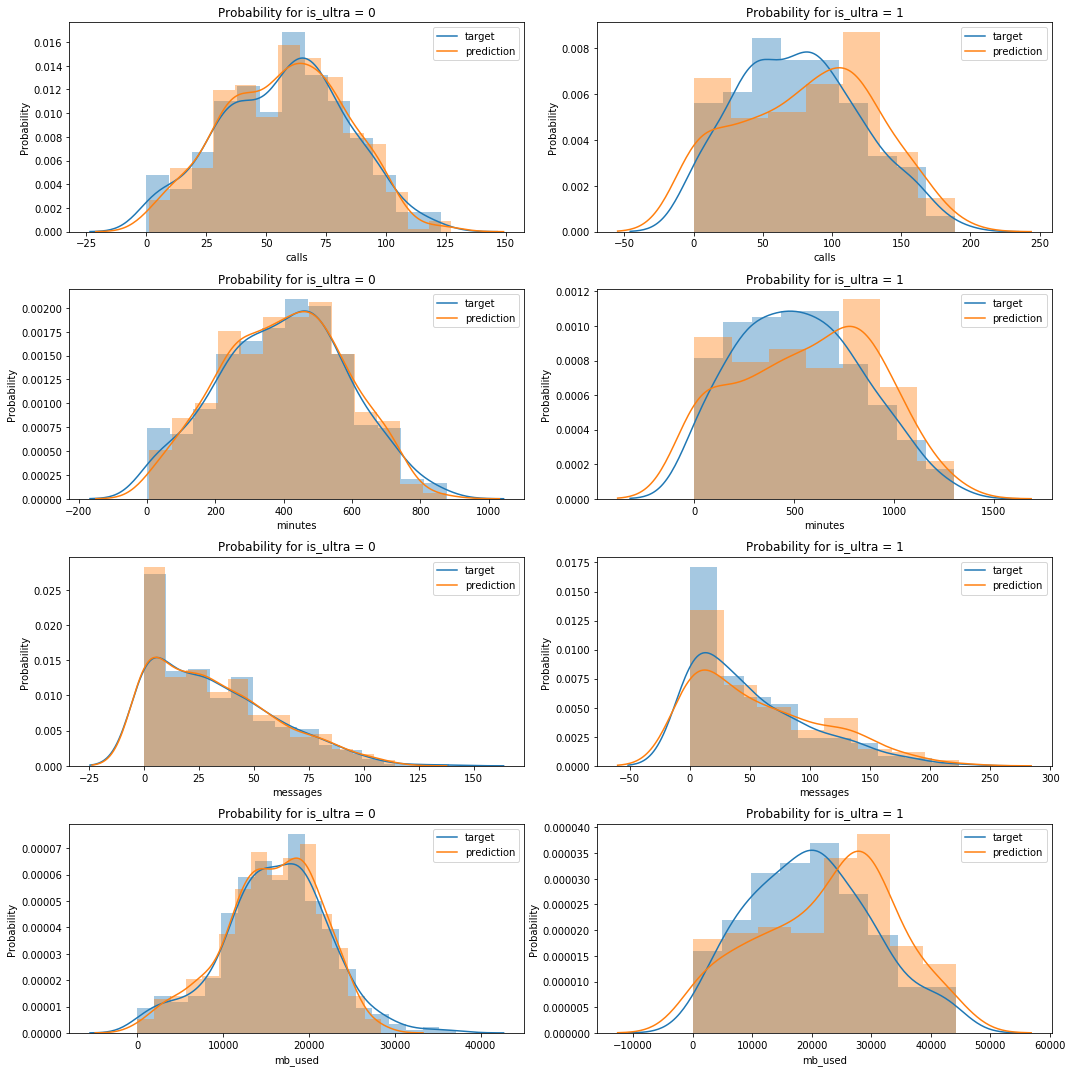

In [41]:
# посмотрим на распределение вероятности для целевой переменной 
# тестовой выборки и предсказаний

features = ['calls', 'minutes', 'messages', 'mb_used']
fig, axes = plt.subplots(len(features), 2, figsize=(15,15))

for i, feature in enumerate(features):
    for j in [0, 1]:
        ax=axes[i][j]
        sns.distplot(predictions_stat[predictions_stat.is_ultra == j][feature], ax=ax);
        sns.distplot(predictions_stat[predictions_stat.pred == j][feature], ax=ax);
        ax.legend(['target','prediction'])
        ax.title.set_text('Probability for is_ultra = {}'.format(j))
        ax.set_ylabel('Probability')

fig.tight_layout()
plt.show() 

In [42]:
data['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Пусть модель всегда будет предсказывать тариф «Смарт». Тогда точность модели будет равна примерно 69%, но точность лучшей модели больше и равна примерно 82.4%. Следовательно, проверка на адекватность пройдена успешно.

## Вывод

В результате работы имеем модель, которая определяет тариф с точностью более 75%. Модель лучше всего определяет тариф _Smart_ - скорее всего из-за того, что данных для тарифа _Ultra_ меньше, чем _Smart_.